In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
#import helper_functions as helper

In [ ]:
'''08/21/2025
    - reformatted the script for better usability 
    - successfully tested and validated electrode to channel mapping
    - tested reading in a binary file (decided it wasnt the best way to go due to non MEA specific recording
    ongoing tasks for today to tick off
    - get the channels to plot traces then change from channels to electrodes 
    - get the electrode x y coordinates, and distance from 0,0 
    - get electrode stats '''

In [2]:
import os
#give path to the IPN Analysis
path = '/home/shruti/MEA_Analysis/IPNAnalysis'
os.chdir(path)


In [19]:
#Reading the file, BP filtering
local_path= '/home/shruti/Downloads/KCNT1_MEAslices/250606_Old/M07896/Network/000003/data.raw.h5' #network data from chip 16848
recording1 = se.read_maxwell(local_path,stream_id = 'well004') # starts with well000 so make sure to use the right one
freq_min = 300
freq_max = 4500


#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=freq_min, freq_max=freq_max)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 500*fs,end_frame=600*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")



Sampling frequency: 10000.0
Number of channels: 899
Number of segments: 1
total_recording: 1200.04 s
chunk duration: 100.0 s


In [20]:
recording_chunk.get_memory_size()


1798000000

In [21]:
#** TESTING THE ELECTRODES MAPPING **#
# Initialize the electrodes list
electrodes = []
channel_location_dict = {}

# Get channel IDs and locations
channel_ids = recording_chunk.get_channel_ids()
locations = recording_chunk.get_channel_locations()

# Populate the electrodes list
for channel, loc in zip(channel_ids, locations):
    # Calculate electrode ID based on location
    electrode_id = 220 * int(loc[1] / 17.5) + int(loc[0] / 17.5)
    electrodes.append(electrode_id)
    channel_location_dict[channel] = electrode_id  # Map channel to electrode

# Validate the electrodes list
if len(electrodes) != len(channel_ids):
    print(f"Warning: Mismatch between number of channels ({len(channel_ids)}) and electrodes ({len(electrodes)}).")
else:
    print(f"Successfully mapped {len(electrodes)} electrodes.")

Successfully mapped 899 electrodes.


In [136]:
electrodes = []
channel_location_dict = {}
channel_ids = recording_chunk.get_channel_ids()
locations = recording_chunk.get_channel_locations()
for channel,locations in zip(channel_ids, locations):
    electrodes.append(220* int(locations[1]/17.5)+int(locations[0]/17.5))

print(electrodes)
print(len(electrodes))
print(channel_ids)

[12910, 16217, 10258, 20402, 13543, 16213, 13981, 9847, 15777, 11380, 15086, 14675, 16203, 11356, 5411, 15117, 12886, 14651, 15739, 17320, 13565, 14010, 11793, 15113, 13580, 14646, 17760, 16179, 11822, 12458, 16196, 13983, 10273, 14005, 12480, 15110, 11353, 12913, 16643, 16225, 14670, 12917, 10253, 8728, 16619, 16638, 9811, 12473, 15741, 21505, 14663, 11786, 18415, 12888, 14022, 11358, 12927, 12446, 12891, 18417, 14020, 13556, 7207, 13553, 18853, 15763, 10285, 7171, 18857, 10270, 13560, 12898, 15787, 10903, 16667, 15765, 19510, 11820, 17308, 17315, 13563, 11796, 8051, 17757, 14660, 14680, 14648, 18398, 11370, 12453, 17753, 10940, 9801, 14008, 13539, 9182, 15098, 15105, 7633, 13551, 18410, 12456, 15122, 13993, 15758, 14003, 13568, 13988, 15125, 7613, 6088, 13548, 18860, 9833, 15751, 14665, 11827, 14017, 16200, 8085, 16621, 22162, 12477, 12439, 16660, 8740, 17726, 20385, 11368, 17728, 16650, 6090, 18393, 16208, 9825, 15100, 12485, 9168, 18391, 19943, 10908, 16623, 16626, 10263, 14639, 10

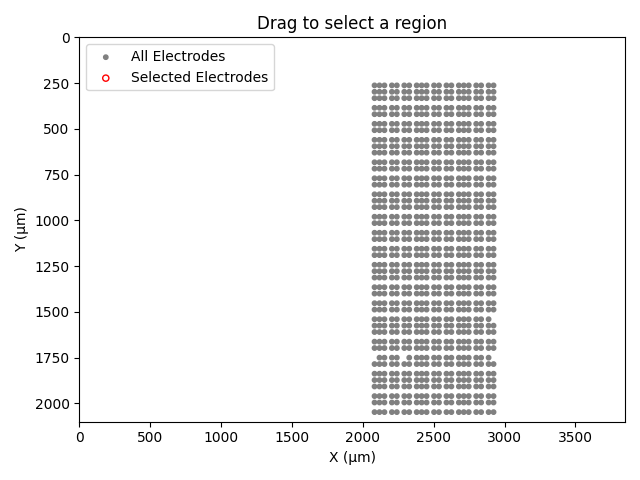

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os

# Enable interactive matplotlib
%matplotlib widget

# Ensure required variables are defined
# Replace these with your actual data
locs = recording_chunk.get_channel_locations()  # 2D locations of electrodes
channel_ids = recording_chunk.get_channel_ids()  # Channel IDs
electrodes = np.array(electrodes)  # List of electrode IDs

# Widgets to enter electrode IDs to highlight
highlight_input = widgets.Text(
    description='Highlight:',
    placeholder='e.g. 10, 15, 23',
    layout=widgets.Layout(width='50%')
)

highlight_button = widgets.Button(
    description='Highlight Electrodes',
    button_style='info'
)

# Setup figure
fig, ax = plt.subplots()

# Initial colors: all gray
c = np.array(['gray'] * len(electrodes))

def update_highlight_colors(electrodes_to_highlight):
    global c
    c = np.array(['gray'] * len(electrodes))
    highlight_mask = np.isin(electrodes, electrodes_to_highlight)
    c[highlight_mask] = 'blue'
    sc.set_color(c)
    fig.canvas.draw_idle()

# Scatter plot of electrode locations
sc = ax.scatter(locs[:, 0], locs[:, 1], c=c, label='All Electrodes', s=10)
ax.set_title("Drag to select a region")
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)")

# Invert the y-axis to match typical electrode layouts
ax.invert_yaxis()

# Scatter plot for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Electrodes')
selected_electrodes = []

# Create an output widget for displaying messages
output = widgets.Output()

# Function to map electrodes to channel numbers
def map_electrodes_to_channels(electrode_list):
    channel_numbers = []
    for electrode in electrode_list:
        if electrode in electrodes:
            channel_index = electrodes.tolist().index(electrode)  # Find the index of the electrode
            channel_numbers.append(channel_ids[channel_index])  # Map to channel number
        else:
            print(f"Electrode {electrode} not found.")
    return list(map(int, channel_numbers))

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_electrodes
    if eclick.xdata is None or erelease.xdata is None:  # Ignore clicks outside the plot
        return

    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata

    # Mask to find electrodes within the selected region
    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = electrodes[mask]

    # Check if Ctrl key is pressed (use event modifiers)
    if eclick.key == 'control':  # Append to existing selection
        selected_electrodes = np.unique(np.concatenate((selected_electrodes, new_selection)))
    else:  # Overwrite selection
        selected_electrodes = new_selection

    # Update the scatter plot for selected electrodes
    selected_plot.set_offsets(locs[np.isin(electrodes, selected_electrodes)])
    fig.canvas.draw_idle()

    # Display the selection details in the output widget
    with output:
        output.clear_output()  # Clear previous messages
        print(f"🔴 Selected {len(selected_electrodes)} electrodes")
        print(selected_electrodes)
        mapped_channels = map_electrodes_to_channels(selected_electrodes)
        print("Mapped Channels:", mapped_channels)
# Create RectangleSelector
selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]  # Left mouse button
)

# Create save button
save_button = widgets.Button(
    description="💾 Save Selected Electrodes",
    button_style='success',
    tooltip='Save selected electrode IDs to file'
)

def on_highlight_button_click(b):
    with output:
        output.clear_output()
        try:
            input_text = highlight_input.value.strip()
            if input_text == "":
                print("No electrodes entered.")
                return
            electrodes_to_highlight = np.array([int(x.strip()) for x in input_text.split(',')])
            update_highlight_colors(electrodes_to_highlight)
            print(f"🔵 Highlighted electrodes: {electrodes_to_highlight}")
        except Exception as e:
            print(f"Error parsing input: {e}")

highlight_button.on_click(on_highlight_button_click)

# Define callback to save to file
def save_selected_electrodes_to_file(b):
    if len(selected_electrodes) == 0:
        with output:
            output.clear_output()
            print("No electrodes selected to save.")
        return

    save_path = "selected_electrodes.txt"
    with open(save_path, "w") as f:
        for el in selected_electrodes:
            f.write(f"{el}\n")

    with output:
        output.clear_output()
        print(f"Saved {len(selected_electrodes)} electrode IDs to {os.path.abspath(save_path)}")

# Attach callback and show button
save_button.on_click(save_selected_electrodes_to_file)

# Display all controls
display(widgets.VBox([
    widgets.HBox([highlight_input, highlight_button]),
    save_button,
    output
]))
plt.xlim([0,3850])
plt.ylim(2100,0)

plt.legend()
plt.tight_layout()
plt.show()

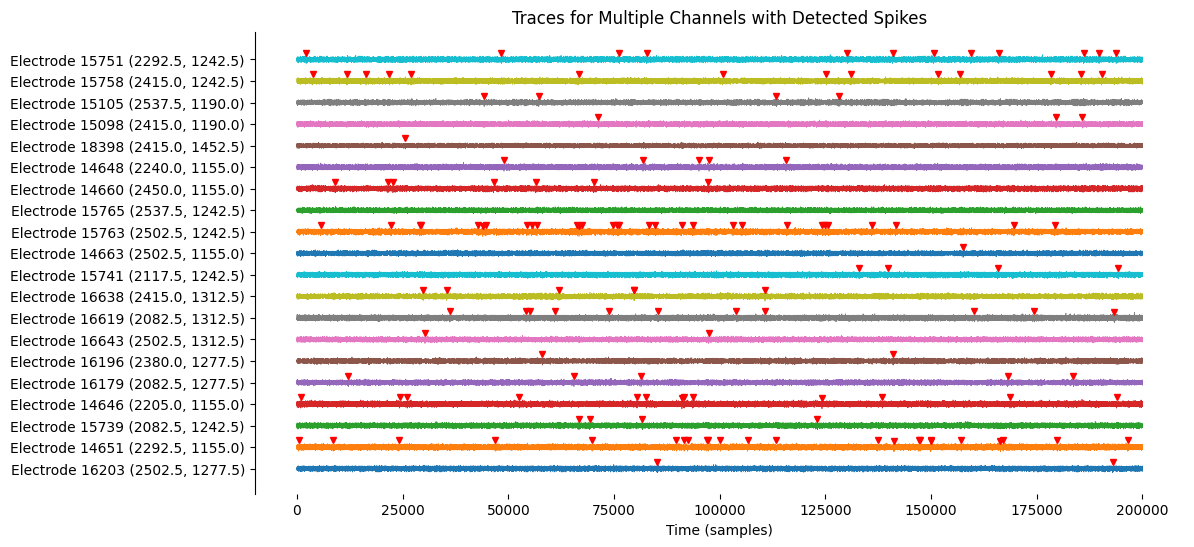

In [31]:
import os

import numpy as np
import matplotlib.pyplot as plt

plt.close('all')  # Close all existing figures to prevent multiple plots

# Define the detect_peaks_stddev function
def detect_peaks_stddev(trace, peak_sign, std_multiplier):
    """
    Detect peaks in a signal based on standard deviation thresholding.

    Parameters:
    - trace: 1D numpy array, the signal to analyze
    - peak_sign: str, "pos" for positive peaks, "neg" for negative peaks
    - std_multiplier: float, the threshold multiplier for peak detection

    Returns:
    - peaks: numpy array, indices of detected peaks
    - threshold: float, the threshold value used for detection
    """
    mean = np.mean(trace)
    std = np.std(trace)
    threshold = mean + std_multiplier * std if peak_sign == "pos" else mean - std_multiplier * std

    if peak_sign == "pos":
        peaks = np.where((trace[1:-1] > trace[:-2]) & (trace[1:-1] > trace[2:]) & (trace[1:-1] > threshold))[0] + 1
    elif peak_sign == "neg":
        peaks = np.where((trace[1:-1] < trace[:-2]) & (trace[1:-1] < trace[2:]) & (trace[1:-1] < threshold))[0] + 1
    else:
        raise ValueError("peak_sign must be 'pos' or 'neg'")

    return peaks, threshold
%matplotlib inline
# Ensure channels_to_plot only contains valid indices within the bounds of the traces array
channels_to_plot = [ 12, 17, 18, 26, 28, 31, 40, 46, 47, 50, 53, 68, 78, 88, 90, 91, 102, 103, 111, 122]
fs = recording_chunk.get_sampling_frequency()
start_time = 40 # Start time in seconds
end_time = 60 # End time in seconds
# Get traces for the specified range
traces = recording_chunk.get_traces(start_frame=int(start_time*fs), end_frame=int(end_time*fs), segment_index=0, return_scaled=True)

# Define the channels you want to plot
 # Replace with the desired channel indices
#channels_to_plot = range(traces.shape[1])  # Example channel indices
# Parameters for spike detection
peak_sign = "neg"  # Detect negative peaks
std_multiplier = 4 # Threshold: 1 standard deviation from the mean

# Adjust figure height dynamically based on the number of channels
plt.figure(figsize=(12, len(channels_to_plot) * 0.3))  # Increase height for better spacing

# Extract channel IDs and 2D location coordinates
channel_ids = np.array([int(x) for x in recording_chunk.get_channel_ids()])
locs = recording_chunk.get_channel_locations()  # Define locs here
# Ensure channels_to_plot only contains valid indices within the bounds of the traces array
channels_to_plot_indices = [np.where(channel_ids == ch)[0][0] for ch in channels_to_plot if ch in channel_ids]

# Loop through the channels and plot each
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store channel names for labeling

spike_times_channel = {} # Store spike times for each channel
for i, channel_idx in enumerate(channels_to_plot_indices):
    # Get the trace for the current channel
    trace = traces[:, channel_idx]
    
    # Detect peaks using the detect_peaks function
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)

    
    # Convert peaks_sample_inds to integers
    peaks_sample_inds = peaks_sample_inds.astype(int)
    spike_times_channel[channel] = peaks_sample_inds  # Store spike times for the channel

    spike_marker_offset = 100
    
    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        label=f'Electrode {electrodes[channel_idx]}',  # Use the actual channel ID for labeling
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )
    
    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Channel {electrodes[channel_idx]}'
    )
    
    # Add y-axis tick position and label
    yticks_positions.append(i * 200)
    
    # Retrieve the x, y coordinates for the channel
    x, y = locs[channel_idx]  # Use the index to get the location
    yticks_labels.append(f'Electrode {electrodes[channel_idx]} ({x:.1f}, {y:.1f})')  # Format with coordinates

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels with Detected Spikes')

# Add y-axis ticks with channel names and coordinates
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './savetraces_multiple_channels_with_spikes.pdf'  # Replace with your desired path
plt.show() 
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)  # Save with high resolution
plt.close()  # Close the plot to free memory

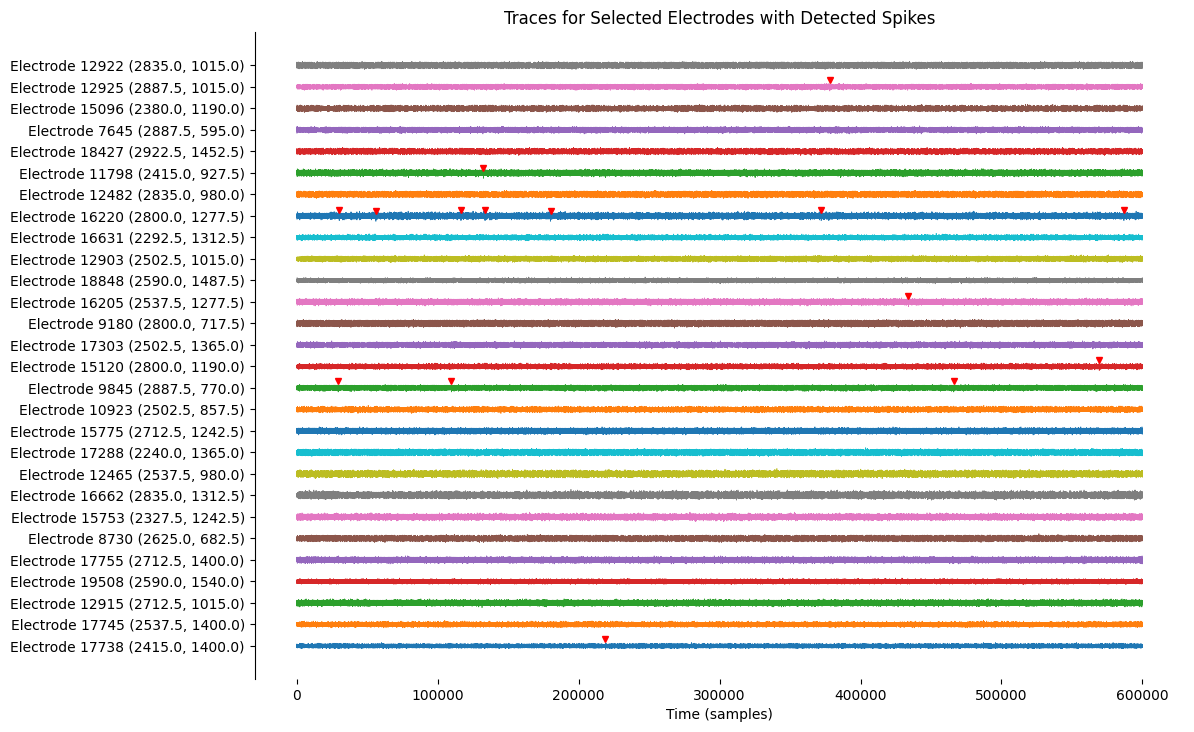

In [27]:
import os

import numpy as np
import matplotlib.pyplot as plt


# Define the detect_peaks_stddev function
def detect_peaks_stddev(trace, peak_sign, std_multiplier):
    """
    Detect peaks in a signal based on standard deviation thresholding.

    Parameters:
    - trace: 1D numpy array, the signal to analyze
    - peak_sign: str, "pos" for positive peaks, "neg" for negative peaks
    - std_multiplier: float, the threshold multiplier for peak detection

    Returns:
    - peaks: numpy array, indices of detected peaks
    - threshold: float, the threshold value used for detection
    """
    mean = np.mean(trace)
    std = np.std(trace)
    threshold = mean + std_multiplier * std if peak_sign == "pos" else mean - std_multiplier * std

    if peak_sign == "pos":
        peaks = np.where((trace[1:-1] > trace[:-2]) & (trace[1:-1] > trace[2:]) & (trace[1:-1] > threshold))[0] + 1
    elif peak_sign == "neg":
        peaks = np.where((trace[1:-1] < trace[:-2]) & (trace[1:-1] < trace[2:]) & (trace[1:-1] < threshold))[0] + 1
    else:
        raise ValueError("peak_sign must be 'pos' or 'neg'")

    return peaks, threshold

%matplotlib inline
plt.close('all')  # Close all existing figures to prevent multiple plots

# Replace this list with the provided electrode numbers
electrodes_to_plot = [
   17738, 17745, 12915, 19508, 17755, 8730, 15753, 16662, 12465, 17288, 15775, 10923, 9845, 15120, 17303, 9180, 16205, 18848, 12903, 16631, 16220, 12482, 11798, 18427, 7645, 15096, 12925, 12922
]

# Sampling frequency
fs = recording_chunk.get_sampling_frequency()

# Define the time range for extracting traces
start_time = 40  # Start time in seconds
end_time = 100    # End time in seconds

# Extract traces from the recording chunk
traces = recording_chunk.get_traces(
    start_frame=int(start_time * fs), 
    end_frame=int(end_time * fs), 
    segment_index=0, 
    return_scaled=True
)

peaks_sign = "neg"  # Peak sign for detection

std_multiplier = 5 # Standard deviation multiplier for peak detection
traces = recording_chunk.get_traces(start_frame=int(start_time*fs), end_frame=int(end_time*fs), segment_index=0, return_scaled=True)


# Map electrodes to their corresponding channel indices
electrodes_to_plot_indices = [np.where(np.array(electrodes) == el)[0][0] for el in electrodes_to_plot if el in electrodes]

# Adjust figure height dynamically based on the number of electrodes
plt.figure(figsize=(12, len(electrodes_to_plot_indices) * 0.3))  # Increase height for better spacing

# Loop through the electrodes and plot each
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store electrode names for labeling

spike_times_electrode = {}  # Store spike times for each electrode
for i, electrode_idx in enumerate(electrodes_to_plot_indices):
    # Get the trace for the current electrode
    trace = traces[:, electrode_idx]
    
    # Detect peaks using the detect_peaks function
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier= std_multiplier)

    # Convert peaks_sample_inds to integers
    peaks_sample_inds = peaks_sample_inds.astype(int)
    spike_times_electrode[electrodes[electrode_idx]] = peaks_sample_inds  # Store spike times for the electrode

    spike_marker_offset = 100
    
    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        label=f'Electrode {electrodes[electrode_idx]}',  # Use the actual electrode ID for labeling
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )
    
    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Electrode {electrodes[electrode_idx]}'
    )
    
    # Add y-axis tick position and label
    yticks_positions.append(i * 200)
    
    # Retrieve the x, y coordinates for the electrode
    x, y = locations[electrode_idx]  # Use the index to get the location
    yticks_labels.append(f'Electrode {electrodes[electrode_idx]} ({x:.1f}, {y:.1f})')  # Format with coordinates

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Selected Electrodes with Detected Spikes')

# Add y-axis ticks with electrode names and coordinates
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './savetraces_selected_electrodes_with_spikes.pdf'  # Replace with your desired path
plt.show()
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)  # Save with high resolution
plt.close()  # Close the plot to free memory

Electrode 3419: 2098.98 μm
Electrode 3859: 2103.64 μm
Electrode 4299: 2108.88 μm
Electrode 4959: 2117.79 μm
Electrode 5399: 2124.43 μm
Electrode 3421: 2133.71 μm
Electrode 6059: 2135.43 μm
Electrode 3861: 2138.30 μm
Electrode 6499: 2143.45 μm
Electrode 4301: 2143.45 μm
Electrode 4961: 2152.22 μm
Electrode 7159: 2156.48 μm
Electrode 5401: 2158.75 μm
Electrode 7599: 2165.83 μm
Electrode 3423: 2168.45 μm
Electrode 6061: 2169.58 μm
Electrode 3863: 2172.96 μm
Electrode 8039: 2175.71 μm
Electrode 6501: 2177.47 μm
Electrode 4303: 2178.03 μm
Electrode 4963: 2186.66 μm
Electrode 7161: 2190.30 μm
Electrode 8699: 2191.49 μm
Electrode 5403: 2193.09 μm
Electrode 7601: 2199.51 μm
Electrode 9139: 2202.64 μm
Electrode 6063: 2203.75 μm
Electrode 8041: 2209.23 μm
Electrode 6503: 2211.52 μm
Electrode 9799: 2220.29 μm
Electrode 3426: 2220.57 μm
Electrode 7163: 2224.15 μm
Electrode 8701: 2224.77 μm
Electrode 3866: 2224.98 μm
Electrode 4306: 2229.93 μm
Electrode 10239: 2232.67 μm
Electrode 7603: 2233.22 μm


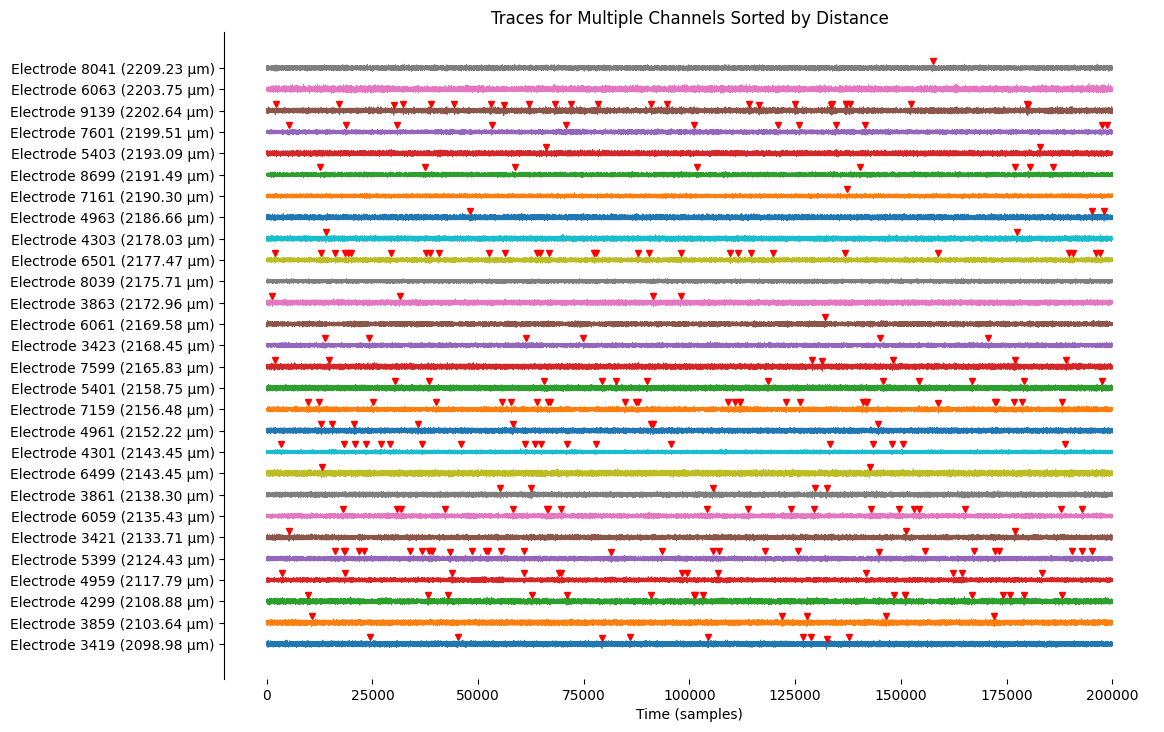

In [32]:
# Sort electrodes based on distance from reference point (0, 0)

import numpy as np
import matplotlib.pyplot as plt

# Define the reference point
reference_point = (0, 0)

# Retrieve the 2D locations of the electrodes
locs = recording_chunk.get_channel_locations()

# Calculate distances for each electrode
distances = np.sqrt((locs[:, 0] - reference_point[0])**2 + (locs[:, 1] - reference_point[1])**2)

# Sort electrodes by distance (ascending order)
sorted_indices = np.argsort(distances)
sorted_electrodes = [electrodes[idx] for idx in sorted_indices]
sorted_distances = distances[sorted_indices]


for electrode, distance in zip(sorted_electrodes, sorted_distances):
    print(f"Electrode {electrode}: {distance:.2f} μm")

# Update the order of electrodes to plot based on sorted electrodes
electrodes_to_plot_sorted = [electrode for electrode in sorted_electrodes if electrode in electrodes_to_plot]


# Validate that electrodes_to_plot_sorted is not empty
if not electrodes_to_plot_sorted:
    raise ValueError("The `electrodes_to_plot_sorted` list is empty. Ensure `electrodes_to_plot` and `electrodes` are correctly defined.")

# Plot the sorted electrodes
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store electrode names for labeling

plt.figure(figsize=(12, len(electrodes_to_plot_sorted) * 0.3))  # Adjust figure height dynamically

spike_marker_offset = 100  # Define spike marker offset

for i, electrode in enumerate(electrodes_to_plot_sorted):
    electrode_idx_array = np.where(np.array(electrodes) == electrode)[0]
    if electrode_idx_array.size == 0:
        print(f"Warning: Electrode {electrode} not found in electrodes.")
        continue  # Skip this electrode if it is not found
    trace = traces[:, electrode_idx_array[0]]
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)

    # Check if spikes are detected
    if len(peaks_sample_inds) == 0:
        print(f"Warning: No spikes detected for electrode {electrode}.")

    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )

    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Electrode {electrodes[electrode_idx]}'
    )
    yticks_positions.append(i * 200)
    yticks_labels.append(f'Electrode {sorted_electrodes[i]} ({sorted_distances[i]:.2f} μm)')

     

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels Sorted by Distance')
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './sorted_traces_by_distance.pdf'
plt.show()
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)
plt.close()



In [63]:
print(len(sorted_indices))

899


In [71]:

for i, electrode_idx in enumerate(sorted_indices):
    print(f"Electrode {electrode}: {distance:.2f} μm")
    # Get the trace for the current electrode
    trace = traces[:, electrode_idx]
    std = np.std(trace)
    rms = np.sqrt(np.mean(trace**2))

    print(f"Std for electrode {electrodes[electrode_idx]}: {std:.2f}")
    print(f"RMS for electrode {electrodes[electrode_idx]}: {rms:.2f}")
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier= std_multiplier)

    # Convert peaks_sample_inds to integers
    peaks_sample_inds = peaks_sample_inds.astype(int)
    spike_times_electrode[electrodes[electrode_idx]] = peaks_sample_inds  # Store spike times for the electrode
    print(f'Electrode {electrodes[electrode_idx]} ({x:.1f}, {y:.1f})')  # Format with coordinates


Electrode 25907: 3568.37 μm
Std for electrode 3419: 7.94
RMS for electrode 3419: 7.94
Electrode 3419 (2292.5, 1242.5)
Electrode 25907: 3568.37 μm
Std for electrode 3859: 7.35
RMS for electrode 3859: 7.35
Electrode 3859 (2292.5, 1242.5)
Electrode 25907: 3568.37 μm
Std for electrode 4299: 9.02
RMS for electrode 4299: 9.02
Electrode 4299 (2292.5, 1242.5)
Electrode 25907: 3568.37 μm
Std for electrode 4959: 7.38
RMS for electrode 4959: 7.38
Electrode 4959 (2292.5, 1242.5)
Electrode 25907: 3568.37 μm
Std for electrode 5399: 9.06
RMS for electrode 5399: 9.06
Electrode 5399 (2292.5, 1242.5)
Electrode 25907: 3568.37 μm
Std for electrode 3421: 6.31
RMS for electrode 3421: 6.31
Electrode 3421 (2292.5, 1242.5)
Electrode 25907: 3568.37 μm
Std for electrode 6059: 12.37
RMS for electrode 6059: 12.37
Electrode 6059 (2292.5, 1242.5)
Electrode 25907: 3568.37 μm
Std for electrode 3861: 7.34
RMS for electrode 3861: 7.34
Electrode 3861 (2292.5, 1242.5)
Electrode 25907: 3568.37 μm
Std for electrode 6499: 7.

In [171]:
results = []

for i, electrode_idx in enumerate(sorted_indices):
    # Get electrode ID
    electrode_id = electrodes[electrode_idx]

    # Trace + stats
    trace = traces[:, electrode_idx]
    std = np.std(trace)
    rms = np.sqrt(np.mean(trace**2))

    # Peak detection
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier=5)
    peaks_sample_inds = peaks_sample_inds.astype(int)

    # Coordinates (make sure x, y are set per electrode!)
    results.append({
        "Electrode": electrode_id,
        "Distance (μm)": distance,
        "Std": std,
        "RMS": rms,
        "Spike Count": len(peaks_sample_inds),
        "Spike Times": peaks_sample_inds.tolist(),
        "X": x,
        "Y": y
    })

# Convert to DataFrame
df_electrode_rms_stats = pd.DataFrame(results)

df_electrode_rms_stats


Electrode  Distance (μm)       Std       RMS  Spike Count  \
0         3419    3568.369726  7.938952  7.938956            0   
1         3859    3568.369726  7.352643  7.352644            0   
2         4299    3568.369726  9.015182  9.015182            0   
3         4959    3568.369726  7.384660  7.384660            0   
4         5399    3568.369726  9.059458  9.059458            0   
..         ...            ...       ...       ...          ...   
894      25245    3568.369726  6.503212  6.503213            0   
895      24807    3568.369726  5.655186  5.655200            0   
896      25247    3568.369726  6.626414  6.626414            0   
897      25905    3568.369726  9.670138  9.670138            2   
898      25907    3568.369726  5.451178  5.451180            0   

        Spike Times       X       Y  
0                []  2292.5  1242.5  
1                []  2292.5  1242.5  
2                []  2292.5  1242.5  
3                []  2292.5  1242.5  
4                []  2292.5  1242.5  
..              ...     ...     ...  
894              []  2292.5  1242.5  
895              []  2292.5  1242.5  
896              []  2292.5  1242.5  
897  [31954, 77181]  2292.5  1242.5  
898              []  2292.5  1242.5  

[899 rows x 8 columns]

In [172]:
# Example: Get number of peaks for a specific electrode
electrode_index = 707  # Replace with the index of your electrode
trace = traces[:, electrode_index]  # Extract the trace for the electrode

# Detect peaks
peaks, threshold = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier=4)

# Total number of peaks for this electrode
num_peaks = len(peaks)
print(f"Total number of peaks for electrode {electrodes[electrode_index]}: {num_peaks}")

Total number of peaks for electrode 13541: 38


In [173]:
# Collect Std and RMS for all electrodes
std_rms_per_electrode = {}
for electrode_index in range(traces.shape[1]):
    trace = traces[:, electrode_index]
    std = np.std(trace)
    rms = np.sqrt(np.mean(trace**2))
    std_rms_per_electrode[electrodes[electrode_index]] = {"Std": std, "RMS": rms}
    print(f"Electrode {electrodes[electrode_index]}: Std = {std:.2f}, RMS = {rms:.2f}")

# Optionally, display as a DataFrame
import pandas as pd
std_rms_df = pd.DataFrame.from_dict(std_rms_per_electrode, orient='index')
display(std_rms_df)

Electrode 12910: Std = 8.27, RMS = 8.27
Electrode 16217: Std = 9.29, RMS = 9.29
Electrode 10258: Std = 7.88, RMS = 7.88
Electrode 20402: Std = 8.77, RMS = 8.77
Electrode 13543: Std = 8.12, RMS = 8.12
Electrode 16213: Std = 8.54, RMS = 8.54
Electrode 13981: Std = 8.38, RMS = 8.38
Electrode 9847: Std = 7.62, RMS = 7.62
Electrode 15777: Std = 8.85, RMS = 8.85
Electrode 11380: Std = 7.13, RMS = 7.13
Electrode 15086: Std = 8.17, RMS = 8.17
Electrode 14675: Std = 9.05, RMS = 9.05
Electrode 16203: Std = 8.51, RMS = 8.51
Electrode 11356: Std = 8.28, RMS = 8.28
Electrode 5411: Std = 6.59, RMS = 6.59
Electrode 15117: Std = 7.82, RMS = 7.82
Electrode 12886: Std = 9.54, RMS = 9.54
Electrode 14651: Std = 9.30, RMS = 9.30
Electrode 15739: Std = 8.50, RMS = 8.50
Electrode 17320: Std = 8.78, RMS = 8.78
Electrode 13565: Std = 11.85, RMS = 11.85
Electrode 14010: Std = 9.08, RMS = 9.08
Electrode 11793: Std = 8.19, RMS = 8.19
Electrode 15113: Std = 8.05, RMS = 8.05
Electrode 13580: Std = 8.14, RMS = 8.14


Std       RMS
12910  8.265611  8.265612
16217  9.289703  9.289704
10258  7.878380  7.878380
20402  8.771969  8.771970
13543  8.124893  8.124900
...         ...       ...
24771  8.438322  8.438323
7180   8.608835  8.608835
4311   7.788898  7.788903
15760  8.476521  8.476522
21048  7.975586  7.975587

[899 rows x 2 columns]

In [174]:
# For each electrode, if std > 6, count as 1 peak, and record amplitude and time of the largest peak
peak_summary = []
fs = recording_chunk.get_sampling_frequency()  # Ensure fs is defined
for electrode_index in range(traces.shape[1]):
    trace = traces[:, electrode_index]
    std = np.std(trace)
    rms = np.sqrt(np.mean(trace**2))
    if rms > 6:
        # Find the largest peak (amplitude and time)
        peak_idx = np.argmax(np.abs(trace))
        amplitude = trace[peak_idx]
        time_point = peak_idx / fs
        peak_summary.append({
            "Electrode": electrodes[electrode_index],
            "Std": std,
            "RMS": rms,
            "Peak_Amplitude": amplitude,
            "Peak_Time_s": time_point
        })
        print(f"Electrode {electrodes[electrode_index]}: Std = {std:.2f}, RMS = {rms:.2f}, Peak Amplitude = {amplitude:.2f}, Time = {time_point:.3f} s")
    else:
        peak_summary.append({
            "Electrode": electrodes[electrode_index],
            "Std": std,
            "RMS": rms,
            "Peak_Amplitude": None,
            "Peak_Time_s": None
        })

# Display as DataFrame
import pandas as pd
peak_summary_df = pd.DataFrame(peak_summary)
display(peak_summary_df)


Electrode 12910: Std = 8.27, RMS = 8.27, Peak Amplitude = 37.77, Time = 7.274 s
Electrode 16217: Std = 9.29, RMS = 9.29, Peak Amplitude = 44.06, Time = 13.393 s
Electrode 10258: Std = 7.88, RMS = 7.88, Peak Amplitude = 31.47, Time = 0.063 s
Electrode 20402: Std = 8.77, RMS = 8.77, Peak Amplitude = 37.77, Time = 0.029 s
Electrode 13543: Std = 8.12, RMS = 8.12, Peak Amplitude = -37.77, Time = 3.738 s
Electrode 16213: Std = 8.54, RMS = 8.54, Peak Amplitude = -37.77, Time = 1.390 s
Electrode 13981: Std = 8.38, RMS = 8.38, Peak Amplitude = 37.77, Time = 1.884 s
Electrode 9847: Std = 7.62, RMS = 7.62, Peak Amplitude = 37.77, Time = 12.129 s
Electrode 15777: Std = 8.85, RMS = 8.85, Peak Amplitude = 44.06, Time = 11.924 s
Electrode 11380: Std = 7.13, RMS = 7.13, Peak Amplitude = 31.47, Time = 2.135 s
Electrode 15086: Std = 8.17, RMS = 8.17, Peak Amplitude = 37.77, Time = 1.721 s
Electrode 14675: Std = 9.05, RMS = 9.05, Peak Amplitude = 44.06, Time = 5.375 s
Electrode 16203: Std = 8.51, RMS = 8

Electrode       Std       RMS  Peak_Amplitude  Peak_Time_s
0        12910  8.265611  8.265612       37.765503       7.2737
1        16217  9.289703  9.289704       44.059753      13.3929
2        10258  7.878380  7.878380       31.471252       0.0626
3        20402  8.771969  8.771970       37.765503       0.0285
4        13543  8.124893  8.124900      -37.765503       3.7378
..         ...       ...       ...             ...          ...
894      24771  8.438322  8.438323       37.765503       1.4338
895       7180  8.608835  8.608835       37.765503       1.4625
896       4311  7.788898  7.788903       37.765503      14.2279
897      15760  8.476521  8.476522       37.765503       0.1540
898      21048  7.975586  7.975587       37.765503      10.4033

[899 rows x 5 columns]

In [176]:
peak_summary_df.sort_values(by="RMS", ascending=False)

Electrode        Std        RMS  Peak_Amplitude  Peak_Time_s
718      17743  16.906847  16.906847      -75.531006       1.5622
702      23228  15.441524  15.441524      -81.825256       4.6862
769      24101  15.088472  15.088475       75.531006      13.4511
750      22121  14.632054  14.632054      -62.942505       3.1344
657      24778  14.140179  14.140179      -62.942505       3.4740
..         ...        ...        ...             ...          ...
347      18833   5.473316   5.473320             NaN          NaN
558      25907   5.451178   5.451180             NaN          NaN
353      21055   5.410967   5.410969             NaN          NaN
682      21495   5.407929   5.407929             NaN          NaN
637      23695   5.380939   5.380940             NaN          NaN

[899 rows x 5 columns]

In [177]:
# Example: Convert spike sample indices to milliseconds for all electrodes
fs = recording_chunk.get_sampling_frequency()  # Sampling frequency in Hz

# Assuming you have a DataFrame like df_electrode_rms_stats with a "Spike Times" column
df_electrode_rms_stats["Spike Times (ms)"] = df_electrode_rms_stats["Spike Times"].apply(
    lambda inds: [((i / 10000)) for i in inds]
)

# Sort the DataFrame by "Spike Count" in descending order and display
df_electrode_rms_stats_sorted = df_electrode_rms_stats.sort_values(by="Spike Count", ascending=False)
# Remove rows with 0 spike count
df_electrode_rms_stats_sorted = df_electrode_rms_stats_sorted[df_electrode_rms_stats_sorted["Spike Count"] > 0]
df_electrode_rms_stats_sorted[["Electrode", "Spike Count", "Spike Times (ms)"]]

Electrode  Spike Count                                   Spike Times (ms)
702      24116           41  [0.3682, 0.9841, 1.1787, 1.3629, 1.5797, 1.951...
638      14677            8  [1.3882, 1.6866, 7.6327, 8.4078, 8.961, 11.247...
644      11822            4                 [3.7303, 9.5716, 10.4828, 15.5035]
572      23668            3                        [14.7322, 16.0399, 19.8139]
138       9153            3                           [6.0875, 7.5792, 7.7285]
..         ...          ...                                                ...
798      23688            1                                           [0.6804]
234      18381            1                                           [11.199]
37        9141            1                                          [19.7731]
235       9820            1                                           [18.004]
292      18386            1                                           [7.6412]

[95 rows x 3 columns]

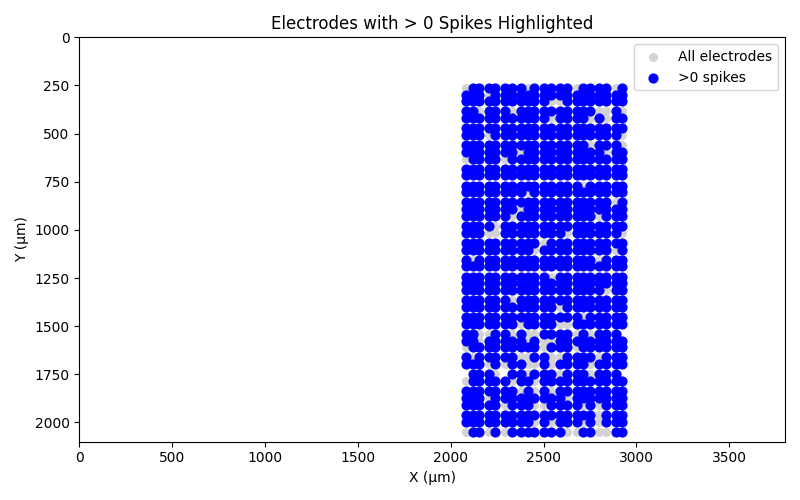

In [178]:
import numpy as np

import matplotlib.pyplot as plt

# Get electrode locations as numpy array
locs = np.array(recording_chunk.get_channel_locations())
electrodes_arr = np.array(electrodes)

# Find electrodes with > 0 spike count
spike_count = np.array([len(spike_times_electrode.get(e, [])) for e in electrodes_arr])
has_spikes = spike_count > 0

# Plot all electrodes in gray
plt.figure(figsize=(8, 5))
plt.scatter(locs[:, 0], locs[:, 1], c='lightgray', s=30, label='All electrodes')

# Highlight electrodes with > 0 spikes in blue
plt.scatter(locs[has_spikes, 0], locs[has_spikes, 1], c='blue', s=40, label='>0 spikes')
plt.xlim([0, 3800])
plt.ylim([0, 2100])
plt.xlabel('X (μm)')
plt.ylabel('Y (μm)')
plt.title('Electrodes with > 0 Spikes Highlighted')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [179]:
# Find index in sorted_electrodes
idx_in_sorted_electrodes = sorted_electrodes.index(11822)
print(idx_in_sorted_electrodes)

644


In [121]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
%matplotlib widget

# Visualize the traces interactively
print("Visualizing traces interactively...")
sw.plot_traces(recording_chunk, mode='line',show_channel_ids=[661, 720, 748, 752, 909, 976], backend='ipywidgets')  # Updated function name

# Create a text box for user input
electrode_input = widgets.Text(
    description="Electrode:",
    placeholder="Enter electrode number",
)

# Create an output widget to display the result
output = widgets.Output()

# Define a function to handle the input and display the corresponding channel indices
def find_channel_indices(change):
    with output:
        output.clear_output()  # Clear previous output
        try:
            # Get the input value and split it into a list of electrode numbers
            electrode_numbers = [int(e.strip()) for e in change["new"].split(",")]
            channel_indices = []
            for electrode_number in electrode_numbers:
                if electrode_number in electrodes:
                    channel_index = electrodes.index(electrode_number)  # Find the index
                    channel_indices.append(channel_index)
                else:
                    print(f"Electrode {electrode_number} not found.")
            if channel_indices:
                print(f"Electrode numbers {electrode_numbers} correspond to Channel Indices {channel_indices}")
        except ValueError:
            print("Please enter valid integers separated by commas.")

# Attach the function to the text box
electrode_input.observe(find_channel_indices, names="value")

# Display the widgets
display(widgets.VBox([electrode_input, output]))



Visualizing traces interactively...


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [181]:
# Function to map electrodes to channel numbers
def map_electrodes_to_channels(electrode_list):
    channel_numbers = []
    for electrode in electrode_list:
        if electrode in electrodes:
            # electrodes is a numpy array, so use np.where to find the index
            channel_index = np.where(electrodes == electrode)[0][0]
            channel_numbers.append(channel_ids[channel_index])  # Map to channel number
        else:
            print(f"Electrode {electrode} not found.")
    return channel_numbers

# Example usage
user_electrode_list = [24101]
mapped_channels = map_electrodes_to_channels(user_electrode_list)
print("Mapped Channels:", mapped_channels)

Mapped Channels: ['894']


In [182]:
# Function to map channel numbers to electrode numbers
def map_channels_to_electrodes(channel_list):
    electrode_numbers = []
    for channel in channel_list:
        if channel in channel_ids.astype(int):
            channel_index = np.where(channel_ids.astype(int) == channel)[0][0]  # Find the index of the channel
            electrode_numbers.append(electrodes[channel_index])  # Map to electrode number
        else:
            print(f"Channel {channel} not found.")
    return electrode_numbers

# Example usage
input_channels = [843]  # Replace with your desired channel numbers
mapped_electrodes = map_channels_to_electrodes(input_channels)
print("Mapped Electrodes:", mapped_electrodes)

Mapped Electrodes: [17743]


In [183]:
peak_summary_df = peak_summary_df.sort_values(by="RMS", ascending=False)
peak_summary_df

Electrode        Std        RMS  Peak_Amplitude  Peak_Time_s
718      17743  16.906847  16.906847      -75.531006       1.5622
702      23228  15.441524  15.441524      -81.825256       4.6862
769      24101  15.088472  15.088475       75.531006      13.4511
750      22121  14.632054  14.632054      -62.942505       3.1344
657      24778  14.140179  14.140179      -62.942505       3.4740
..         ...        ...        ...             ...          ...
347      18833   5.473316   5.473320             NaN          NaN
558      25907   5.451178   5.451180             NaN          NaN
353      21055   5.410967   5.410969             NaN          NaN
682      21495   5.407929   5.407929             NaN          NaN
637      23695   5.380939   5.380940             NaN          NaN

[899 rows x 5 columns]

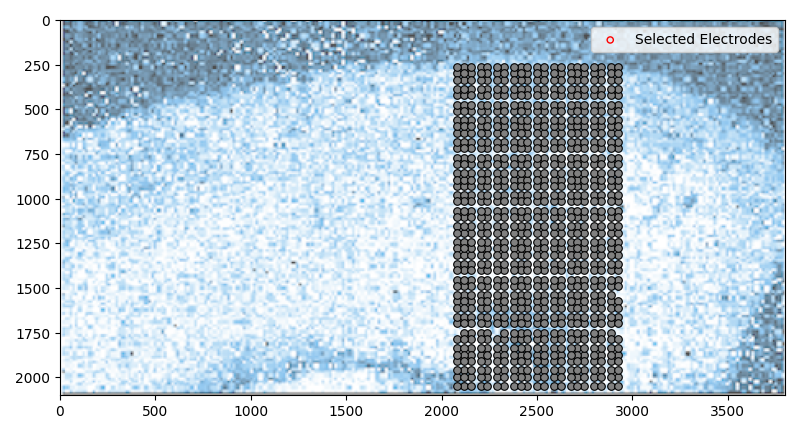

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os

from matplotlib.image import imread

# Enable interactive matplotlib
%matplotlib widget

# Load the background image
img_path = "/home/shruti/MEA_Analysis/IPNAnalysis/plotting_MEAslices/run6_well5_M07037.png"
img = imread(img_path)

# Get electrode locations
locs = recording_chunk.get_channel_locations()
channel_ids = recording_chunk.get_channel_ids()
electrodes = np.array(electrodes)

# Determine extent for the image (fit to locs)
# Define full plot extent to cover entire brain slice (adjust to your known coordinates)
x_min, x_max = 0, 3800
y_min, y_max = 0, 2100


# Calculate aspect ratio of the image
img_height, img_width = img.shape[:2]
aspect_ratio = img_width / img_height

# Set figure size with correct aspect ratio (tune fig_width as desired)
fig_width = 8  # inches
fig_height = fig_width / aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Show image with extent matching electrode locations and invert y for coordinate match
# Show background image spanning entire coordinate range
ax.imshow(img, extent=[x_min, x_max, y_max, y_min], aspect='auto', alpha=0.7)
# After displaying image, plot electrodes
electrode_marker_size = 30  # increase size for visibility
electrode_edge_color = 'black'
# Electrode scatter plot remains unchanged (already in correct coordinates)
sc = ax.scatter(
    locs[:, 0], locs[:, 1],
    c='grey',
    s=30,
    edgecolors='black',
    linewidth=0.8
)

# Set axis limits tightly to image extents to fill whole graph
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_max, y_min)  # y inverted

# Invert y-axis explicitly for MEA layout matching
#ax.invert_yaxis()


# Scatter plot for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Electrodes')
selected_electrodes = []

# Widgets to enter electrode IDs to highlight
highlight_input = widgets.Text(
    description='Highlight:',
    placeholder='e.g. 10, 15, 23',
    layout=widgets.Layout(width='50%')
)
highlight_button = widgets.Button(
    description='Highlight Electrodes',
    button_style='info'
)
output = widgets.Output()

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_electrodes
    if eclick.xdata is None or erelease.xdata is None:
        return
    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata
    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = electrodes[mask]
    if eclick.key == 'control':
        selected_electrodes = np.unique(np.concatenate((selected_electrodes, new_selection)))
    else:
        selected_electrodes = new_selection
    selected_plot.set_offsets(locs[np.isin(electrodes, selected_electrodes)])
    fig.canvas.draw_idle()
    with output:
        output.clear_output()
        print(f"🔴 Selected {len(selected_electrodes)} electrodes")
        print(selected_electrodes)

selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]
)

save_button = widgets.Button(
    description="💾 Save Selected Electrodes",
    button_style='success',
    tooltip='Save selected electrode IDs to file'
)

def on_highlight_button_click(b):
    with output:
        output.clear_output()
        try:
            input_text = highlight_input.value.strip()
            if input_text == "":
                print("No electrodes entered.")
                return
            electrodes_to_highlight = np.array([int(x.strip()) for x in input_text.split(',')])
            update_highlight_colors(electrodes_to_highlight)
            print(f"🔵 Highlighted electrodes: {electrodes_to_highlight}")
        except Exception as e:
            print(f"Error parsing input: {e}")

highlight_button.on_click(on_highlight_button_click)

def save_selected_electrodes_to_file(b):
    if len(selected_electrodes) == 0:
        with output:
            output.clear_output()
            print("No electrodes selected to save.")
        return
    save_path = "selected_electrodes.txt"
    with open(save_path, "w") as f:
        for el in selected_electrodes:
            f.write(f"{el}\n")
    with output:
        output.clear_output()
        print(f"Saved {len(selected_electrodes)} electrode IDs to {os.path.abspath(save_path)}")

save_button.on_click(save_selected_electrodes_to_file)
display(widgets.VBox([
    widgets.HBox([highlight_input, highlight_button]),
    save_button,
    output
]))


plt.legend()
plt.tight_layout()
plt.show()

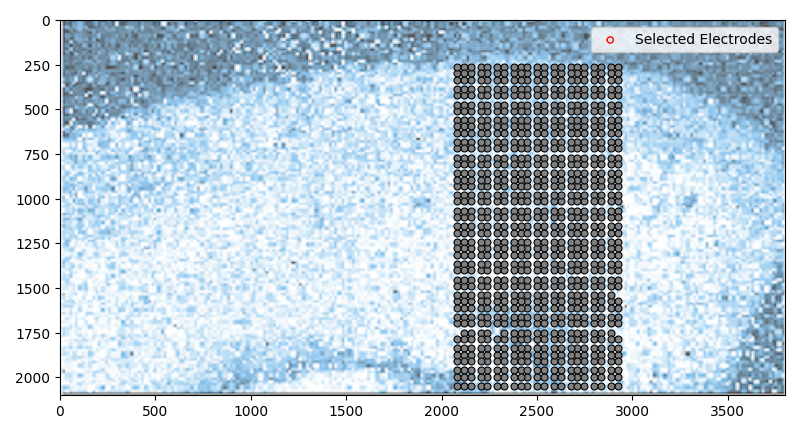

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os

from matplotlib.image import imread

# Enable interactive matplotlib
%matplotlib widget

# Load the background image
img_path = "/home/shruti/MEA_Analysis/IPNAnalysis/plotting_MEAslices/run6_well5_M07037.png"
img = imread(img_path)

# Get electrode locations
locs = recording_chunk.get_channel_locations()
channel_ids = recording_chunk.get_channel_ids()
electrodes = np.array(electrodes)

# Determine extent for the image (fit to locs)
# Define full plot extent to cover entire brain slice (adjust to your known coordinates)
x_min, x_max = 0, 3800
y_min, y_max = 0, 2100


# Calculate aspect ratio of the image
img_height, img_width = img.shape[:2]
aspect_ratio = img_width / img_height

# Set figure size with correct aspect ratio (tune fig_width as desired)
fig_width = 8  # inches
fig_height = fig_width / aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Show image with extent matching electrode locations and invert y for coordinate match
# Show background image spanning entire coordinate range
ax.imshow(img, extent=[x_min, x_max, y_max, y_min], aspect='auto', alpha=0.7)
# After displaying image, plot electrodes
electrode_marker_size = 30  # increase size for visibility
electrode_edge_color = 'black'
# Electrode scatter plot remains unchanged (already in correct coordinates)
sc = ax.scatter(
    locs[:, 0], locs[:, 1],
    c='grey',
    s=25,
    edgecolors='black',
    linewidth=0.8
)

# Set axis limits tightly to image extents to fill whole graph
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_max, y_min)  # y inverted

# Invert y-axis explicitly for MEA layout matching
#ax.invert_yaxis()


# Scatter plot for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Electrodes')
selected_electrodes = []

# Widgets to enter electrode IDs to highlight
highlight_input = widgets.Text(
    description='Highlight:',
    placeholder='e.g. 10, 15, 23',
    layout=widgets.Layout(width='50%')
)
highlight_button = widgets.Button(
    description='Highlight Electrodes',
    button_style='info'
)
output = widgets.Output()

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_electrodes
    if eclick.xdata is None or erelease.xdata is None:
        return
    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata
    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = electrodes[mask]
    if eclick.key == 'control':
        selected_electrodes = np.unique(np.concatenate((selected_electrodes, new_selection)))
    else:
        selected_electrodes = new_selection
    selected_plot.set_offsets(locs[np.isin(electrodes, selected_electrodes)])
    fig.canvas.draw_idle()
    with output:
        output.clear_output()
        print(f"🔴 Selected {len(selected_electrodes)} electrodes")
        print(selected_electrodes)

selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]
)

save_button = widgets.Button(
    description="💾 Save Selected Electrodes",
    button_style='success',
    tooltip='Save selected electrode IDs to file'
)

def on_highlight_button_click(b):
    with output:
        output.clear_output()
        try:
            input_text = highlight_input.value.strip()
            if input_text == "":
                print("No electrodes entered.")
                return
            electrodes_to_highlight = np.array([int(x.strip()) for x in input_text.split(',')])
            update_highlight_colors(electrodes_to_highlight)
            print(f"🔵 Highlighted electrodes: {electrodes_to_highlight}")
        except Exception as e:
            print(f"Error parsing input: {e}")

highlight_button.on_click(on_highlight_button_click)

def save_selected_electrodes_to_file(b):
    if len(selected_electrodes) == 0:
        with output:
            output.clear_output()
            print("No electrodes selected to save.")
        return
    save_path = "selected_electrodes.txt"
    with open(save_path, "w") as f:
        for el in selected_electrodes:
            f.write(f"{el}\n")
    with output:
        output.clear_output()
        print(f"Saved {len(selected_electrodes)} electrode IDs to {os.path.abspath(save_path)}")

save_button.on_click(save_selected_electrodes_to_file)
display(widgets.VBox([
    widgets.HBox([highlight_input, highlight_button]),
    save_button,
    output
]))


plt.legend()
plt.tight_layout()
plt.show()

In [197]:
# Check if electrode 3453 is in the DataFrame index
if 3453 in df_electrode_rms_stats.index:
    print(df_electrode_rms_stats.loc[3453])
else:
    print("Electrode 3453 not found in df_electrode_rms_stats.")

Electrode 3453 not found in df_electrode_rms_stats.


In [196]:
print(df_electrode_rms_stats.sort_values(by="RMS", ascending=False))

     Electrode  Distance (μm)        Std        RMS  Spike Count Spike Times  \
516      17743    3568.369726  16.906847  16.906847            0          []   
545      23228    3568.369726  15.441524  15.441524            1     [46862]   
492      24101    3568.369726  15.088472  15.088475            0          []   
390      22121    3568.369726  14.632054  14.632054            0          []   
748      24778    3568.369726  14.140179  14.140179            0          []   
..         ...            ...        ...        ...          ...         ...   
404      18833    3568.369726   5.473316   5.473320            1    [192670]   
898      25907    3568.369726   5.451178   5.451180            0          []   
791      21055    3568.369726   5.410967   5.410969            0          []   
800      21495    3568.369726   5.407929   5.407929            0          []   
843      23695    3568.369726   5.380939   5.380940            0          []   

          X       Y Spike Times (ms)  


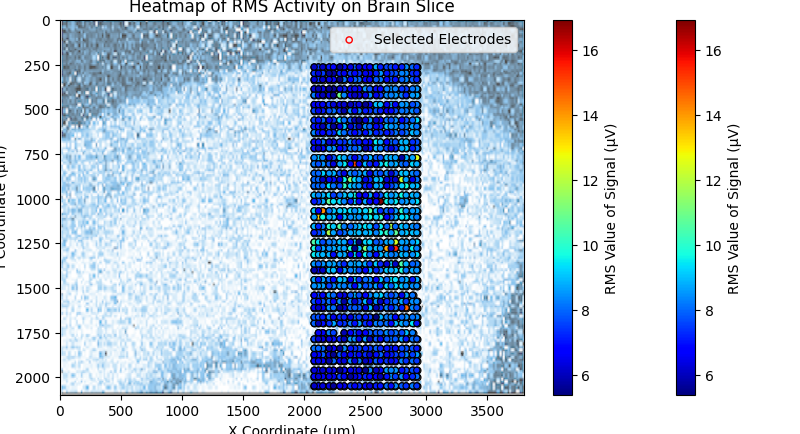

In [202]:
# Instead of plotting electrodes in grey, use RMS values from df_electrode_rms_stats
electrode_marker_size = 20
electrode_edge_color = 'black'

# Align RMS values to the electrode order
# Assuming locs[:,0], locs[:,1] correspond to the same electrodes in df_electrode_rms_stats
# If order mismatch, merge on 'Electrode' instead
x_coords = df_electrode_rms_stats["X"].values
y_coords = df_electrode_rms_stats["Y"].values
rms_values = df_electrode_rms_stats["RMS"].values

# Scatter with RMS as colormap
sc = ax.scatter(
    locs[:, 0], locs[:, 1],
    c=rms_values,
    cmap="jet",
    s=electrode_marker_size,
    edgecolors=electrode_edge_color,
    linewidth=0.8
)


# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("RMS Value of Signal (µV)")


# Axis labels and title
ax.set_xlabel("X Coordinate (µm)")
ax.set_ylabel("Y Coordinate (µm)")
ax.set_title("Heatmap of RMS Activity on Brain Slice")

plt.show()


In [ ]:
'''BREAK UNTIL GOOD CODE'''

In [56]:
mean = np.mean(trace)
std_values = []
for e in electrodes:
    std_ch = np.std(trace)
    std_values.append(std_ch)
print(std_values)
print(mean)

[8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 8.10517, 

In [10]:
locations = recording_chunk.get_channel_locations()
print(locations.shape)
channel_ids = recording_chunk.get_channel_ids()
print(channel_ids.shape)

(899, 2)
(899,)


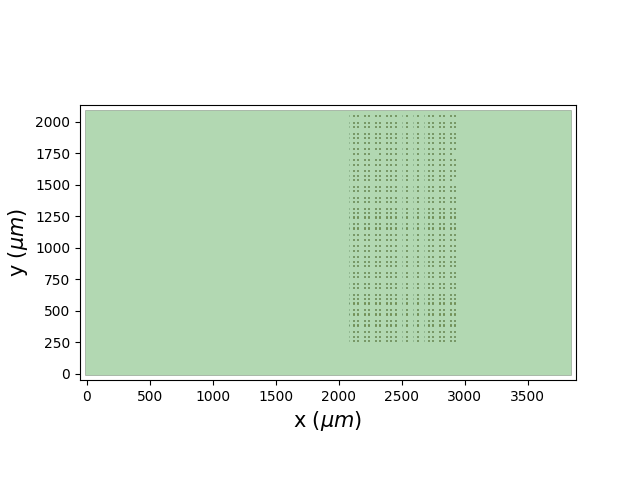

In [34]:
import spikeinterface.widgets as sw

sw.plot_probe_map(recording_chunk)




In [ ]:
sw.plot_unit_waveforms_density_map(sorting, recording)
sw.plot_unit_waveforms(sorting, recording, unit_ids=[0, 1, 2], max_channels=10)